# Recursive QAOA

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import json
import os
import joblib

from openqaoa.qaoa_parameters import QAOACircuitParams, create_qaoa_variational_params, Hamiltonian
from openqaoa.devices import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import *
from openqaoa.workflows.optimizer import QAOA, RQAOA
from openqaoa.problems.problem import QUBO, MaximumCut, MinimumVertexCover

In [2]:
# Set plotting style
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
#plt.rcParams['font.size'] = '12'
#plt.rc('font', family='serif', size=600)

sns.axes_style("whitegrid")
sns.set_context("paper", font_scale=2.5)

In [3]:
def random_k_regular_graph_normal_distribution(degree: int,
                           nodes: List[int],
                           seed: int = None,
                           weighted: bool = False,
                           sigma: float = 1.0,
                           mu: float = 0.0,
                           biases: bool = False) -> nx.Graph:
    """
    Produces a random graph with specified number of nodes, each having degree k.

    Parameters
    ----------
    degree: `int`
        Desired degree for the nodes.
    nodes: `list`
        The node set of the graph.
    seed: `int`, optional
        A seed for the random number generator.
    weighted: `bool`, optional
        Whether the edge weights should be uniform or different. If false, all weights are set to 1.
        If true, the weight is set to a random number drawn from the uniform distribution in the
        interval 0 to 1.
    biases: `bool`, optional
        Whether or not the graph nodes should be assigned a weight.
        If true, the weight is set to a random number drawn from the uniform
        distribution in the interval 0 to 1.

    Returns
    -------
    nx.Graph: `Networkx Graph`
        A graph with the properties as specified.
    """
    # Set numpy seed
    np.random.seed(seed=seed)

    # Create a random regular graph on the nodes
    G = nx.random_regular_graph(degree, len(nodes), seed)

    # Relabel nodes
    nx.relabel_nodes(G, {i: n for i, n in enumerate(nodes)})

    # Add edges between nodes
    for edge in G.edges():

        # If weighted attribute is False, all weights are set to 1
        if not weighted:
            G[edge[0]][edge[1]]['weight'] = 1

        # If weighted attribute is True, weights are assigned as random integers
        else:
            G[edge[0]][edge[1]]['weight'] = np.random.normal(mu, sigma)

    # If biases attribute is True, add node weights as random integers
    if biases:
        for node in G.nodes():
            G.nodes[node]['weight'] = np.random.rand()

    return G

In [4]:
# helper function to produce the cost landscape
def create_cost_landscape_std(hamiltonian, betas, gammas):
    """
    This function constructs a 2-D array containing cost values for different pairs
    of parameter values.
    
    """
    
    cost_landscape = np.zeros((betas.size, gammas.size), dtype=float)
    
    for i, beta in enumerate(betas):
        for j, gamma in enumerate(gammas):
            variational_params = [beta, gamma]
            cost_landscape[i,j] = energy_expectation_analytical(variational_params, hamiltonian)
            
           
    return cost_landscape

In [5]:
def plot_landscape(cost_landscape, betas, gammas, sigma, mu):

    plt.contourf(cost_landscape, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))

    #plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\beta$')
    plt.colorbar()
    #plt.savefig("cost_landscape_sigma={}_mu={}.png".format(sigma, mu))
    plt.show()
    

In [6]:
def plot_landscape_with_opt_trajectory(cost_landscape, optimization_angles, betas, gammas, optimizer):
    plt.contourf(cost_landscape, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))
        
    plt.plot(optimization_angles[:, 1], optimization_angles[:, 0], '--', color='black',  )  
    plt.plot(optimization_angles[0, 1], optimization_angles[0, 0], 'x', color='black',  ) 
    
    plt.plot(optimization_angles[-1, 1], optimization_angles[-1, 0], 'x', color='orange',  )

    #plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\beta$')
    plt.colorbar()
    plt.savefig("cost_landscape_trajectory_optimizer={}.png".format(optimizer))
    plt.show()

### Analyze experiment

In [83]:
experiment_name = 'Maxcut_w3R_initializations_smallest_region' # to be used as a name for the folder containing all jsons for this experiment 
# structure of the name: problem_typeOfGraph[optional]_variableToInvestigate

mu = 5.0

sigma_list = [10]
#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]
optimizer_list = ["cobyla"]
graph_seed_list = [23]
init_seed_list = [8000]


data = []

for sigma in sigma_list:
    print("Sigma=", sigma) 
    for graph_seed in graph_seed_list:
        print("graph_seed=", graph_seed)
        for optimizer in optimizer_list:
            print("Optimizer=", optimizer)
            for init_seed in init_seed_list:
                print("init_seed=", init_seed)
                
                # Opening JSON file
                with open("{}/mu_{}__sigma_{}__graphSeed_{}_optimizer_{}__initSeed_{}.json".format(experiment_name, mu, sigma, graph_seed, optimizer, init_seed)) as f:

                    # returns JSON object as a dictionary
                    opt_results = json.load(f)

                    # construct the original problem Hamiltonian from the initial QAOA 
                    qaoa_init = opt_results['intermediate_steps'][0]['QAOA']
                    terms = []
                    for i in range(0, len(qaoa_init['cost_hamiltonian']['terms'])):
                        terms.append(qaoa_init['cost_hamiltonian']['terms'][i]['qubit_indices'])
                    weights = qaoa_init['cost_hamiltonian']['coeffs']
                    const = qaoa_init['cost_hamiltonian']['constant']

                    cost_hamiltonian = Hamiltonian.classical_hamiltonian(terms, weights, const)

                    analytical_energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

                    # Calculate the approx. ratio
                    optimization_energy = list(opt_results['solution'].values())[0]

                    r = np.abs(optimization_energy) / np.abs(analytical_energy)

                    # Extract other params
                    optimization_schedule = list(opt_results['schedule'])

                    optimization_angles = np.array(opt_results['intermediate_steps'][3]['QAOA']['intermediate']['angles log'])
    
                    data.append([sigma, graph_seed, init_seed, optimizer, r])
        



Sigma= 10
graph_seed= 23
Optimizer= cobyla
init_seed= 8000


In [86]:
qaoa_init['cost_hamiltonian']

{'n_qubits': 12,
 'terms': [{'qubit_indices': [0, 1], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [0, 10], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [0, 8], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [1, 8], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [1, 10], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [2, 3], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [2, 7], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [2, 6], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [3, 5], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [3, 11], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [4, 5], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [4, 9], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [4, 10], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [5, 9], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [6, 7], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_indices': [6, 8], 'pauli_str': 'ZZ', 'phase': 1},
  {'qubit_

In [84]:
betas = np.linspace(0, np.pi, 100)
gammas = np.linspace(0, np.pi, 100)

cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)

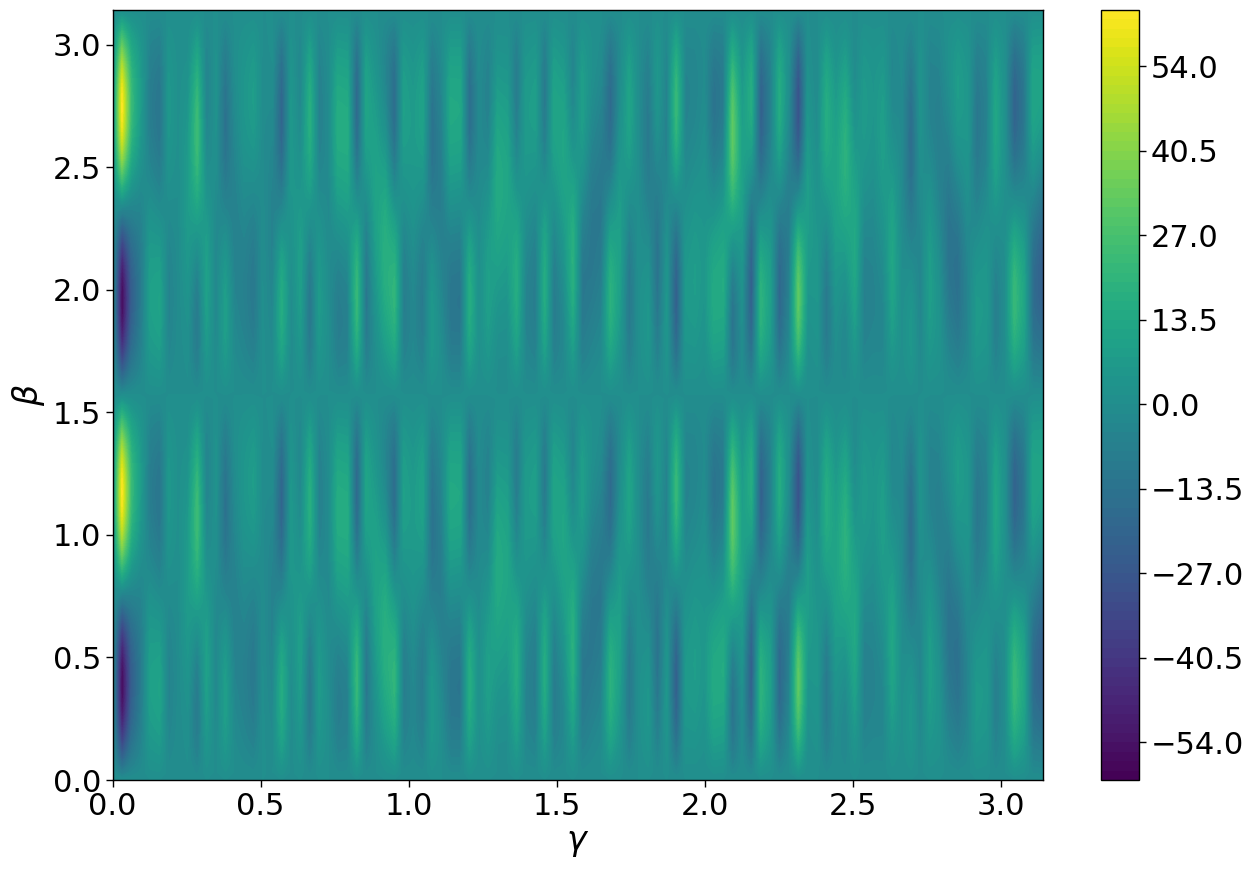

In [85]:
plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


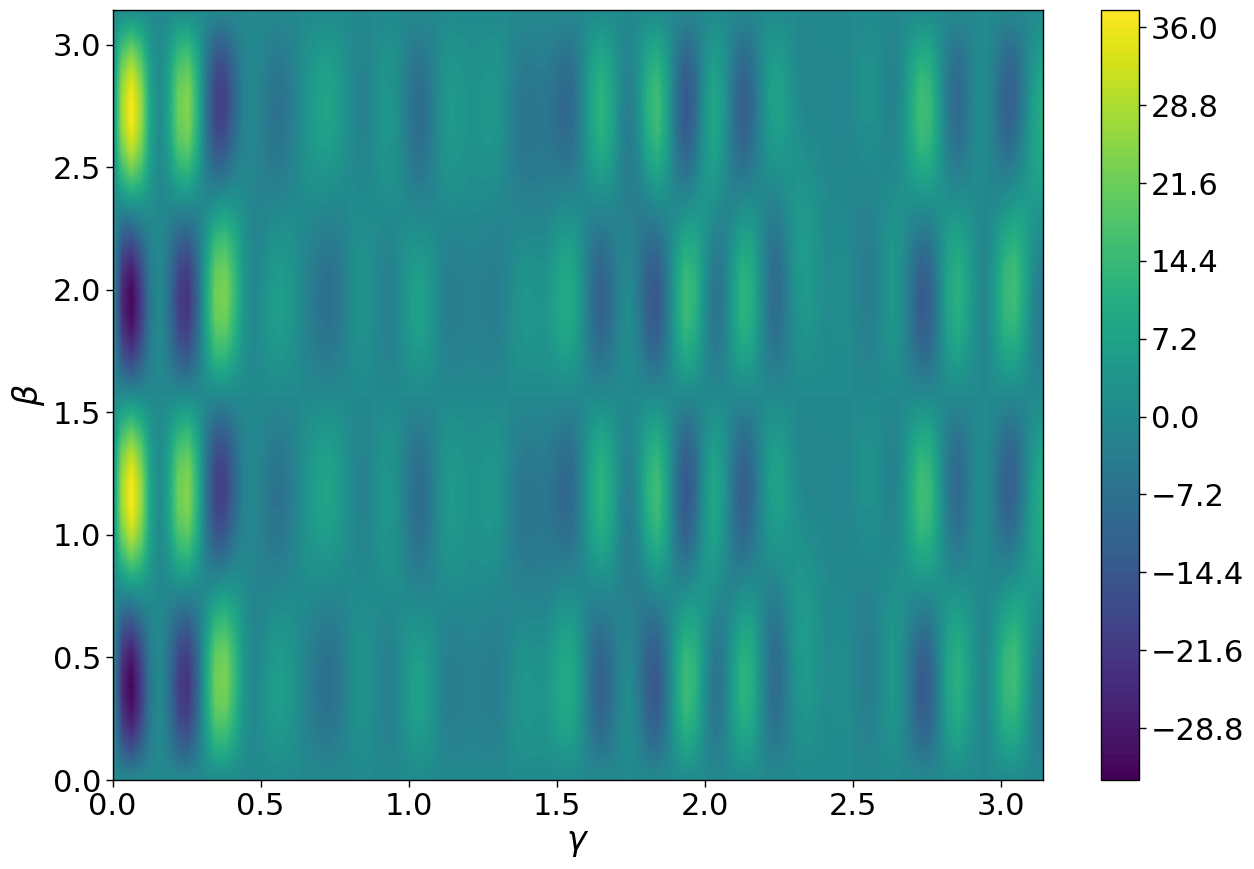

In [78]:
plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


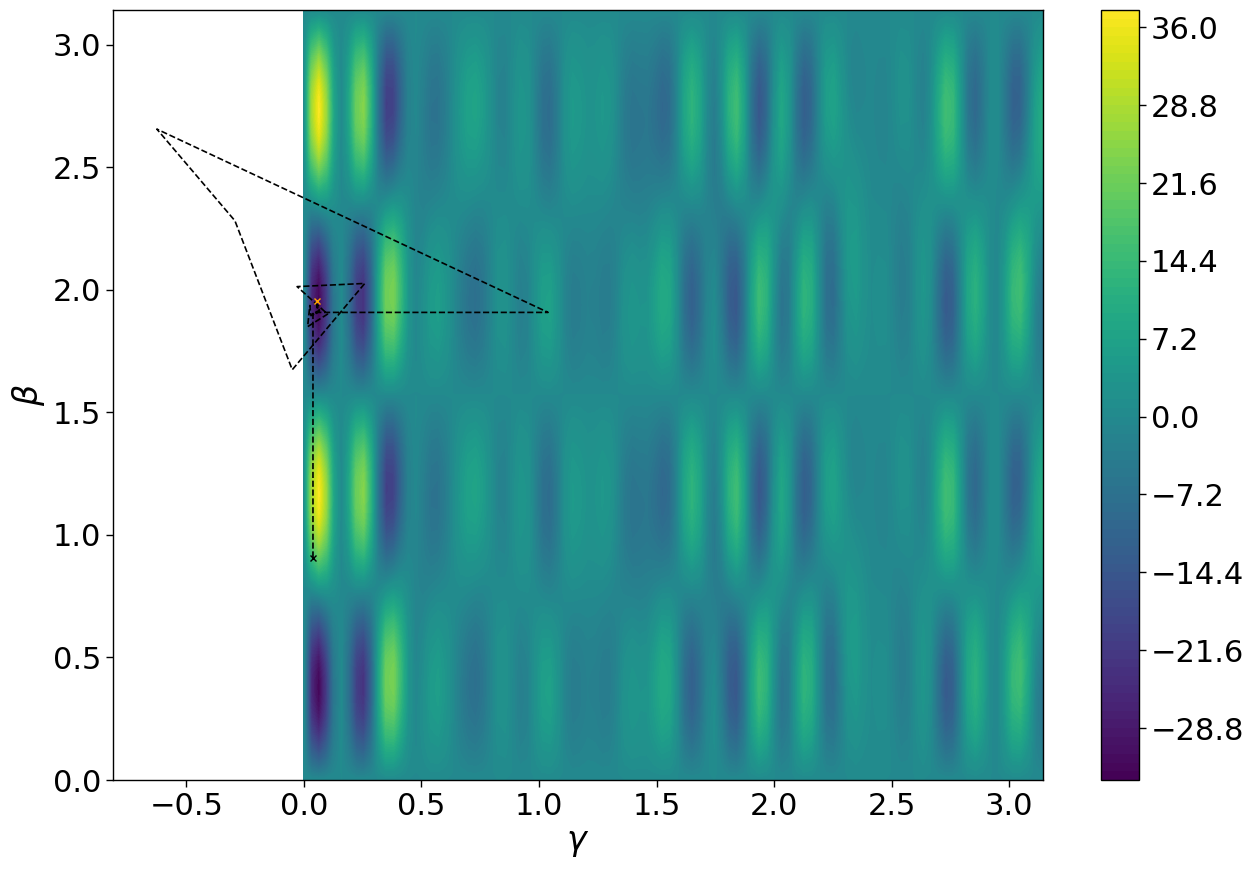

In [79]:
plot_landscape_with_opt_trajectory(cost_landscape_std, optimization_angles, betas, gammas, optimizer)